**Jour 2**





**Importations**

In [1]:
!pip install transformers
%pip install sentence-transformers --quiet
!pip install ttable
!pip install sklearn

import pandas as pd
import re
import os
import math
import numpy as np
from itertools import product
import numpy as np
from transformers import AutoTokenizer
import string 
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from scipy.sparse import find
from sentence_transformers import SentenceTransformer
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
from sklearn.preprocessing import normalize
from nltk.corpus import stopwords
from sklearn.metrics.pairwise import cosine_similarity
import pickle
from sklearn.preprocessing import MinMaxScaler





from google.colab import drive
drive.mount('/content/drive')

MAIN_PATH = '/content/drive/MyDrive/TP Centrale'
DATA_PATH = '/content/drive/MyDrive/TP Centrale/data'


#Importation de la base de données
import os
posts = pd.read_xml(os.path.join(DATA_PATH, 'Posts.xml'), parser="etree", encoding="utf8")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 56.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 36.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.3/122.3 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ttable: filename=ttable-0.6.4-cp310-cp310-linux_x86_64.whl size=212631 sha256=462b77c7d1ba9b60b2eb7a5818fb86c579f640fbbb919ffcba9bdc9d574edb9f
  Stored in directory: /root/.cache/pip/wheels/0d/8d/56/f2572fdbf1ef1f8a947d7f

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Mounted at /content/drive


**Preprocessing**

In [6]:
#Fonction pour extraire les mots en minuscule, sans ponctuation
def extract_words(text: str) -> list:
    tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
    tokens = tokenizer.tokenize(text)
    tokens = [''.join(c for c in t if c not in string.punctuation) for t in tokens]
    tokens = [t for t in tokens if t]
    return tokens

#Fonction qui crée un dataframe Panda avec deux colonnes : le texte brut et les mots qui en sont extraits. 
def index_docs(docs: list[str]) -> pd.DataFrame:
    df = pd.DataFrame(docs, columns=['raw_text'])
    df['words'] = df['raw_text'].apply(extract_words)
    return df


#Fonction qui enlève le tags HTML 
def remove_tags(text: str) -> str:
    TAG_RE = re.compile(r'<[^>]+>')
    return TAG_RE.sub('', text)


In [7]:
#Création du dataframe clean_posts
clean_posts = posts[['Id','Body']]
clean_posts['Clean Body'] = clean_posts['Body'].fillna('').apply(remove_tags)
clean_posts = clean_posts.iloc[0:1000]
clean_posts['words'] = clean_posts['Clean Body'].apply(extract_words)
clean_posts

<ipython-input-7-62c8f16dec35>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_posts['Clean Body'] = clean_posts['Body'].fillna('').apply(remove_tags)
Token indices sequence length is longer than the specified maximum sequence length for this model (569 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (517 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (679 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the spe

,Id,Body,Clean Body,words
0,5,<p>I've always been interested in machine lear...,I've always been interested in machine learnin...,"[i, ve, always, been, interested, in, machine,..."
1,7,"<p>As a researcher and instructor, I'm looking...","As a researcher and instructor, I'm looking fo...","[as, a, researcher, and, instructor, i, m, loo..."
2,9,"<p>Not sure if this fits the scope of this SE,...","Not sure if this fits the scope of this SE, bu...","[not, sure, if, this, fits, the, scope, of, th..."
3,10,"<p>One book that's freely available is ""The El...","One book that's freely available is ""The Eleme...","[one, book, that, s, freely, available, is, th..."
4,14,<p>I am sure data science as will be discussed...,I am sure data science as will be discussed in...,"[i, am, sure, data, science, as, will, be, dis..."
...,...,...,...,...
995,1109,<p>Undersampling the majority class is usually...,Undersampling the majority class is usually th...,"[under, sam, pling, the, majority, class, is, ..."
996,1110,<p>I want to cluster a set of long-tailed / pa...,I want to cluster a set of long-tailed / paret...,"[i, want, to, cluster, a, set, of, long, taile..."
997,1112,<ul>\n<li>Max Kuhn covers this well in Ch16 of...,\nMax Kuhn covers this well in Ch16 of Applied...,"[max, ku, hn, covers, this, well, in, ch, 16, ..."
998,1113,<p>I have a general methodological question. I...,I have a general methodological question. I ha...,"[i, have, a, general, method, ological, questi..."


In [8]:
#Création de l'index inversé après avoir créé une colonne 'words' sur le dataframe clean_posts

def create_index(posts: pd.DataFrame) -> dict:
    inverted_index = defaultdict(set)

    for index, row in posts.iterrows():
        for word in row['words']:
            inverted_index[word].add(index)

    return inverted_index

inverted_index = create_index(clean_posts)
inverted_index['tuned']

{23, 69, 107, 806, 952}

In [9]:
#Implémentation de la méthode de recherche

# Inputs : a word (str) & a list of words
# Output : pandas series of 1 if the word is in the list, else 0

def word_in_index(word, word_list_index):
    # Initialize an empty list to store results
    results = []

    for words in word_list_index:
        if word in words:
            results.append(1)
        else:
            results.append(0)

    series_results = pd.Series(results)
    return series_results


#Function which run through a pandas series and count the number of word in common
# Inputs : the query (str) & pandas series of strings
# Output : Pandas series counting the number of common words between the query and each string in word_serie

def count_common_words(query, word_serie):
  common = pd.Series(0, index=word_serie.index)
  for word in extract_words(query):
    for index, string in word_serie.iteritems() :
      if word in extract_words(string):
        common.loc[index] += 1
  return common
    

#Fonction qui renvoie les 5 premiers résultats à une query 

def rank_top_query(query, df, top=5):
  data = count_common_words(query, df['Clean Body'])
  sorteddata = data.sort_values(ascending=False)
  return sorteddata.head(top)

#convertir en df ??

In [10]:
rank_top_query(query="testing the query in python", df=clean_posts, top=5)

<ipython-input-9-ccb42989da17>:27: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, string in word_serie.iteritems() :
Token indices sequence length is longer than the specified maximum sequence length for this model (569 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (517 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (679 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (540 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for th

KeyboardInterrupt: ignored

In [ ]:
clean_posts.loc[273]['Clean Body']

In [11]:
#Fonction qui renvoie une liste des mots dans les stops-words
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

def remove_stop_words(l_txt: list) -> list:
    stop_words = set(stopwords.words('english'))

    l_txt = [word for word in l_txt if word not in stop_words]

    return l_txt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


**Jour 3**

In [12]:
#Reload
posts = pd.read_xml(os.path.join(DATA_PATH, 'Posts.xml'), parser="etree", encoding="utf8")

In [6]:
#Fonction qui nettoie le post en enlevant les tags HTML
def remove_tags(text: str) -> str:
    TAG_RE = re.compile(r'<[^>]+>')
    return TAG_RE.sub('', text)

def clean_post(text:str)->str:
    clean_post = remove_tags(text)
    return clean_post

posts['Clean Body'] = posts['Body'].fillna('').apply(clean_post)

In [5]:
#De même pour la query 
def clean_query(text:str)->str:
    cleaned_query = remove_tags(text)
    return cleaned_query

In [18]:
#Vectorisation TF IDF
vectorizer = TfidfVectorizer(stop_words='english')
vectorizer.fit(posts['Clean Body'].values)
vectors = vectorizer.transform(posts['Clean Body'].values)

def vectorize_query(query : str, vectorizer=vectorizer):
    cleaned_query = clean_query(query)
    query_vectorized = vectorizer.transform([cleaned_query])
    return query_vectorized

def vectorizer_search(query : str,
                      vectors=vectors,
                      vectorizer=vectorizer) -> list:

    query_vectorized = vectorize_query(query, vectorizer)
    similarities = cosine_similarity(query_vectorized, vectors)
    top10_indexes = similarities.argsort()[0][::-1].tolist()[:10]
    closest_items = posts.iloc[top10_indexes]
    return closest_items['Clean Body']

entry = 'what is stochastic gradient descent ?'
vectorizer = TfidfVectorizer(stop_words='english')
vectorizer.fit(posts['Clean Body'].values)
vectors = vectorizer.transform(posts['Clean Body'].values)
closest_items = vectorizer_search(entry, vectors, vectorizer)
closest_items

22952    What is the difference between Gradient Descen...
34094    As I know, Gradient Descent has three variants...
52361    I am a student and I am studying machine learn...
45984    Both algorithms are quite similar. The only di...
17863    It depends a bit on your definition, usually t...
8374     In neural nets, the back-propagation algorithm...
56184    Stochastic Gradient Descent (SGD) is an iterat...
42036    First, using the appropriate terminology you c...
12642    Conjugate gradient descent is a variation on g...
34727    Gradient Descent is an optimization method use...
Name: Clean Body, dtype: object

In [16]:
#Modèle de recherche sémantique 

sentence_transformer_model = 'all-MiniLM-L6-v2' 
MODEL_ST = SentenceTransformer(sentence_transformer_model)
embeddings = MODEL_ST.encode(posts['Clean Body'].values, normalize_embeddings=True)
with open(os.path.join(DATA_PATH, 'embeddings.pkl'), 'wb') as file:
    pickle.dump(embeddings, file)

In [8]:
def encode_query(query : str) ->  np.ndarray:
    encoded_query = MODEL_ST.encode([query], normalize_embeddings=True)
    encoded_query.reshape(1,-1)
    return encoded_query

#Crée la matrice de similarité
def similarity(query, embeddings=embeddings):
    encoded_query = encode_query(query)
    similarity_matrix = cosine_similarity(encoded_query, embeddings)
    return similarity_matrix

#Renvoie l'index des documents classé selon la similarité
def ordre_en_fonction_similarité(matrix_similarity):
    sorted_similarity = matrix_similarity[0].argsort()
    ordre = sorted_similarity[::-1]
    return ordre

#Remet tout ça ensemble pour renvoyer les 10 dix documents les plus similaires sémantiquement
def closest_semantic_doc(query, embeddings=embeddings, top_n=10):
    top10_index = ordre_en_fonction_similarité(similarity(query, embeddings))[:10]
    closest_posts = posts.iloc[top10_index]['Clean Body']
    return closest_posts

In [18]:
answer = closest_semantic_doc('what is stochastic gradient descent ?', embeddings)
answer

22952    What is the difference between Gradient Descen...
56184    Stochastic Gradient Descent (SGD) is an iterat...
56185    Stochastic Gradient Descent (SGD) is an iterat...
14038    From my understanding, a stochastic process wh...
34727    Gradient Descent is an optimization method use...
52361    I am a student and I am studying machine learn...
39988    Stochastic Gradient Descent (SGD) is an optimi...
39984    Is backpropagation a learning method or an opt...
17863    It depends a bit on your definition, usually t...
22956    The inclusion of the word stochastic simply me...
Name: Clean Body, dtype: object

In [61]:
query_list= [' mesure performance for multiclassification model', 'draw neural network', 'neural network layers', 'how sklearn working', 'treat categorical data']

def calculate_ndcg(relevance_scores, k):
    dcg = relevance_scores[0] + np.sum(relevance_scores[1:k] / np.log2(np.arange(2, k + 1)))
    sorted_scores = np.sort(relevance_scores)[::-1]
    idcg = sorted_scores[0] + np.sum(sorted_scores[1:k] / np.log2(np.arange(2, k + 1)))
    ndcg = dcg / idcg if idcg > 0 else 0
    return ndcg
  
list_ndgc = [calculate_ndcg(similarity(query, embeddings)[0], 10) for query in query_list]
list_ndgc

[0.09294084744000806,
 0.11765207272447838,
 0.20185170734932176,
 0.28979349139546245,
 0.20307905898728498]

In [3]:
#Fonction qui va nettoyer le titre car on veut créer une colonne 'clean_title'
def clean_title(title:str)->str:
   text = re.sub('<.*?>', '', str(title)).lower()
   return text

posts['cleaned_title'] = posts.Title.apply(clean_title)
posts['cleaned_title']

0        how can i do simple machine learning without h...
1        what open-source books (or other materials) pr...
2                                                     none
3                                                     none
4                 is data science the same as data mining?
                               ...                        
75722    back propagation on arbitrary depth network wi...
75723                          evaluation parameter in knn
75724    can i use zero-padded input and output layers ...
75725    why does cross validation and hyperparameter t...
75726                  high metrics value (mae, mse, rmse)
Name: cleaned_title, Length: 75727, dtype: object

In [20]:
model_title='all-MiniLM-L6-v2' 
MODEL_TI = SentenceTransformer(model_title)

In [21]:
titles = MODEL_TI.encode(posts.cleaned_title.values)
titles

array([[-0.00736339, -0.05472134,  0.05072233, ...,  0.09360052,
        -0.06571408, -0.01612387],
       [-0.05249904, -0.07805733, -0.00304246, ..., -0.00160703,
        -0.00019503,  0.04180059],
       [ 0.00240443, -0.04070057, -0.07673121, ..., -0.05409698,
        -0.00372312, -0.01124114],
       ...,
       [-0.03753242, -0.08825061,  0.0299333 , ...,  0.01282675,
        -0.00316134,  0.0098701 ],
       [-0.02683008, -0.03471702, -0.00160326, ..., -0.01683   ,
         0.02148416, -0.0032071 ],
       [ 0.03878613, -0.08041832, -0.02028871, ..., -0.17452718,
        -0.0414587 ,  0.01576328]], dtype=float32)

In [22]:
#On refait le 
def final_matrix(query,titles=titles,embeddings=embeddings):
  encoded_query=MODEL_ST.encode([query],convert_to_tensor=True)[0]
  encoded_query_cpu=encoded_query.cpu().detach().numpy()
  similarity_matrix_body = cosine_similarity(encoded_query_cpu.reshape(1, -1), embeddings)
  encoded_query_titles=MODEL_TI.encode([query],convert_to_tensor=True)[0]
  encoded_query_cpu_titles=encoded_query_titles.cpu().detach().numpy()
  similarity_matrix_title= cosine_similarity(encoded_query_cpu_titles.reshape(1, -1), titles)
  final_mat = 0.9*similarity_matrix_body + 0.1*similarity_matrix_title
  return final_mat

def closest_docs(query, embeddings=embeddings, top_n=10):
    top10_index = ordre_en_fonction_similarité(final_matrix(query, titles, embeddings))[:10]
    closest_posts = posts.iloc[top10_index]['Clean Body']
    return closest_posts


query1 = ' mesure performance for multiclassification model'
query2 = 'draw neural network'
query3 = 'neural network layers'
query4 = 'how sklearn working'
query5 = 'treat categorical data'
closest_docs(query3,titles,embeddings)


38038    I was watching Andrew Ng's video on ResNets, a...
8275     If we have MLP then we can easily compute the ...
57621    Is there such a thing as a double sided neural...
27635    I was given the task as follows,\n\n\n  Scrape...
10300    From Wang et al (2015) "Visual Tracking with F...
4544     Here is my code to implement the learning of m...
26036    When I first read about neural networks, I lea...
65641    In my textbook I read that an MLP and linear a...
17092    In classical neural nets, we have that each la...
56395    I am implementing single layer neural network ...
Name: Clean Body, dtype: object

In [15]:
def calculate_ndcg(rdgc, ridcg, k):
    dcg = rdcg[0] + np.sum(rdcg[1:k] / np.log2(np.arange(2, k + 1)))
    idcg = ridcg[0] + np.sum(ridcg[1:k] / np.log2(np.arange(2, k + 1)))
    ndcg = dcg / idcg if idcg > 0 else 0
    return ndcg


query_list= [' mesure performance for multiclassification model', 'draw neural network', 'neural network layers', 'how sklearn working', 'treat categorical data']
query3 = 'neural network layers'
dcg = [final_matrix(query3, titles, embeddings)[0][i] for i in [6170, 15989, 13490, 12321, 22, 14899, 5706, 15135, 12851, 694, 9302, 9443]]
rdcg = np.sort(dcg)
F = final_matrix(query3, titles, embeddings)[0]
ridcg = [F[6107], F[5706], F[694], F[12851], F[14899], F[9302], F[15989], F[13490], F[12321], F[22], F[15135], F[9443]]

calculate_ndcg(rdcg, ridcg, 12)


0.8211848176323371

**Merging of TFD-IDF and Semantic**

In [7]:
posts = pd.read_xml(os.path.join(DATA_PATH, 'Posts.xml'), parser="etree", encoding="utf8")
posts['Clean Body'] = posts['Body'].fillna('').apply(clean_post)
posts['cleaned_title'] = posts.Title.apply(clean_title)
vectorizer = TfidfVectorizer(stop_words='english')
vectorizer.fit(posts['Clean Body'].values)
vectors = vectorizer.transform(posts['Clean Body'].values)
sentence_transformer_model = 'all-MiniLM-L6-v2' 
MODEL_ST = SentenceTransformer(sentence_transformer_model)
embeddings = MODEL_ST.encode(posts['Clean Body'].values, normalize_embeddings=True)
with open(os.path.join(DATA_PATH, 'embeddings.pkl'), 'wb') as file:
    pickle.dump(embeddings, file)
model_title='all-MiniLM-L6-v2' 
MODEL_TI = SentenceTransformer(model_title)
titles = MODEL_TI.encode(posts.cleaned_title.values)

In [23]:
def vectorizer_search_score_matrix(query : str,
                      vectors=vectors,
                      vectorizer=vectorizer) -> list:

    query_vectorized = vectorize_query(query, vectorizer)
    vector_similarities = cosine_similarity(query_vectorized, vectors)
    return vector_similarities

#tfidf_matrix_score = vectorizer_search_score_matrix(test_query, vectors, vectorizer)
#semantic_matrix_score = final_matrix(test_query, titles, embeddings)

def merged_score(vectorizer_search_score_matrix, semantic_search_score_matrix ):
  merged_score = (vectorizer_search_score_matrix + semantic_search_score_matrix)/2
  return merged_score

def closest_docs_merged_methods(query, embeddings=embeddings):
    vectorizer_search_score_matrixx = vectorizer_search_score_matrix(query, vectors, vectorizer)
    semantic_search_score_matrix = final_matrix(query, titles, embeddings)
    top10_index = ordre_en_fonction_similarité(merged_score(vectorizer_search_score_matrixx,semantic_search_score_matrix))[:10]
    closest_posts = posts.iloc[top10_index]['Clean Body']
    return closest_posts


test_query = 'neural network layers'
closest_docs_merged_methods(test_query, embeddings)




query3 = 'neural network layers'
F = merged_score(vectorizer_search_score_matrix(query3, vectors, vectorizer),final_matrix(query3, titles, embeddings))[0]
dcg = [F[i] for i in [6170, 15989, 13490, 12321, 22, 14899, 5706, 15135, 12851, 694, 9302, 9443]]
rdcg = np.sort(dcg)
ridcg = [F[6107], F[5706], F[694], F[12851], F[14899], F[9302], F[15989], F[13490], F[12321], F[22], F[15135], F[9443]]

calculate_ndcg(rdcg, ridcg, 12)

0.8164069111631518

**Pistes d'amélioration : Filtrage par dates **

In [37]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime
from datetime import datetime
from collections import Counter

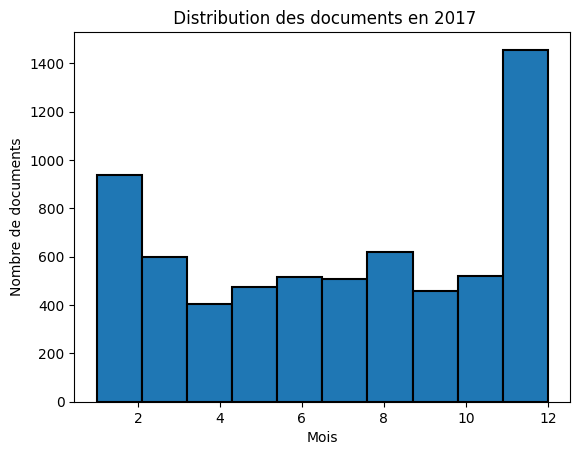

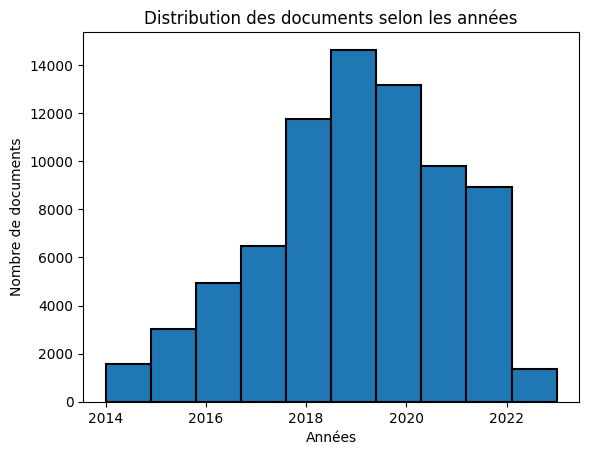

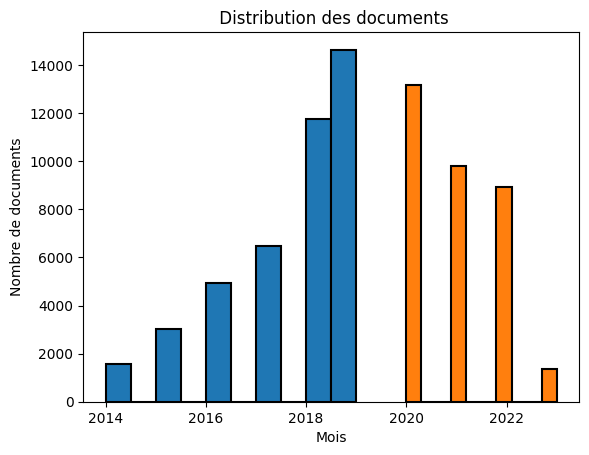

In [38]:
posts1 = pd.read_xml(os.path.join(DATA_PATH, 'Posts.xml'), parser="etree", encoding="utf8")
posts1

#Récupération des dates sans la lettre "T"

def date_sans_T(date) : 
  nom = ""
  for i in date :
    if i == "T":
      nom = nom + " "
    else : 
      nom = nom + i
  return nom

#convertion des dates en str en date.time 
def convert_date(date_time):
    format = "%Y-%m-%d %H:%M:%S.%f" # The format
    datetime_str = datetime.strptime(date_time, format)
 
    return datetime_str

# Algorithme qui sort le mois correspondant à la date d'entrée si y est l'année indiquée 
def dates_20dy(date,y): 
  nom = '' 
  if date.year == y :
    return date.month

# algorithme qui renvoie la liste d'occurence de chaque terme de la liste d'entrée
def compter_occurrences(termes):
    occurrences = Counter(termes)
    liste_occurrences = [occurrence for terme, occurrence in occurrences.items()]
    return liste_occurrences

# Tracé de l'histogramme du nombre de documents par mois selon l'année y

def hist_20y(date,y): 
  all_dates = [convert_date(date_sans_T((date[i]))) for i in range (0, len(date)) ] #convertion de toutes les dates en date.time
  dates_y = [dates_20dy(i,y) for i in all_dates if dates_20dy(i,y) != None ] #liste de toutes les dates de l'année y 

 # Tracer l'histogramme
  plt.hist(dates_y, edgecolor='black', linewidth=1.5)

# Ajouter un titre et des labels d'axe
  plt.title(" Distribution des documents en " + str(y))
  plt.xlabel("Mois")
  plt.ylabel("Nombre de documents")

  # Affichage de l'histogramme
  plt.show()

hist_20y(posts1["CreationDate"],2017)

# Tracé de l'histogramme du nombre de documents par années

def hist_all(date): 
  all_dates = [convert_date(date_sans_T((date[i]))) for i in range (0, len(date)) ] #convertion de toutes les dates en date.time
  all_dates_year = [i.year for i in all_dates] #liste de toutes les années 

  
  # Tracer l'histogramme
  plt.hist(all_dates_year, edgecolor='black', linewidth=1.5)

# Ajouter un titre et des labels d'axe
  plt.title("Distribution des documents selon les années")
  plt.xlabel("Années")
  plt.ylabel("Nombre de documents")

  # Affichage de l'histogramme
  plt.show()

hist_all(posts1["CreationDate"])

# Tracé de l'histogramme du nombre de documents avant 2019 et après 2019

def hist_20y_bis(date): 
  all_dates = [convert_date(date_sans_T((date[i]))) for i in range (0, len(date)) ] #convertion de toutes les dates en date.time
  all_dates_year = [i.year for i in all_dates] #liste de toutes les années 
  L = compter_occurrences(all_dates_year) # liste qui compte l'occurence des termes de all_dates_year
  L1 = sorted(list(set(all_dates_year))) # liste ordonnée des années 


  y = L1[L.index(max(L))] #année qui compte le plus de documents, ici 2019 

  L2 = [i for i in all_dates_year if i <=y] #liste des années avant ou égale à y
  L3 = [i for i in all_dates_year if i > y] #liste des années après y

  

 # Tracer l'histogramme
  plt.hist(L2, edgecolor='black', linewidth=1.5)
  plt.hist(L3, edgecolor='black', linewidth=1.5)


# Ajouter un titre et des labels d'axe
  plt.title(" Distribution des documents")
  plt.xlabel("Mois")
  plt.ylabel("Nombre de documents")



  # Affichage de l'histogramme
  plt.show()

hist_20y_bis(posts1["CreationDate"])

**Correction d'orthographe**

In [39]:
def generate_candidates(word):
    candidates = []

    # Insertion
    for i in range(len(word) + 1):
        for char in 'abcdefghijklmnopqrstuvwxyz':
            candidate = word[:i] + char + word[i:]
            candidates.append(candidate)

    # Deletion
    for i in range(len(word)):
        candidate = word[:i] + word[i+1:]
        candidates.append(candidate)

    # Substitution
    for i in range(len(word)):
        for char in 'abcdefghijklmnopqrstuvwxyz':
            candidate = word[:i] + char + word[i+1:]
            candidates.append(candidate)

    # Transposition
    for i in range(len(word) - 1):
        candidate = word[:i] + word[i+1] + word[i] + word[i+2:]
        candidates.append(candidate)

    # Permutation
    if len(word) >= 2:
        for i in range(len(word) - 1):
            candidate = word[:i] + word[i+1] + word[i] + word[i+2:]
            candidates.append(candidate)

    return candidates

# Example usage
word = "hello"
candidates = generate_candidates(word)
print(candidates)

['ahello', 'bhello', 'chello', 'dhello', 'ehello', 'fhello', 'ghello', 'hhello', 'ihello', 'jhello', 'khello', 'lhello', 'mhello', 'nhello', 'ohello', 'phello', 'qhello', 'rhello', 'shello', 'thello', 'uhello', 'vhello', 'whello', 'xhello', 'yhello', 'zhello', 'haello', 'hbello', 'hcello', 'hdello', 'heello', 'hfello', 'hgello', 'hhello', 'hiello', 'hjello', 'hkello', 'hlello', 'hmello', 'hnello', 'hoello', 'hpello', 'hqello', 'hrello', 'hsello', 'htello', 'huello', 'hvello', 'hwello', 'hxello', 'hyello', 'hzello', 'heallo', 'hebllo', 'hecllo', 'hedllo', 'heello', 'hefllo', 'hegllo', 'hehllo', 'heillo', 'hejllo', 'hekllo', 'helllo', 'hemllo', 'henllo', 'heollo', 'hepllo', 'heqllo', 'herllo', 'hesllo', 'hetllo', 'heullo', 'hevllo', 'hewllo', 'hexllo', 'heyllo', 'hezllo', 'helalo', 'helblo', 'helclo', 'heldlo', 'helelo', 'helflo', 'helglo', 'helhlo', 'helilo', 'heljlo', 'helklo', 'helllo', 'helmlo', 'helnlo', 'helolo', 'helplo', 'helqlo', 'helrlo', 'helslo', 'heltlo', 'helulo', 'helvlo',

In [41]:
!pip install pyxdameraulevenshtein
import pyxdameraulevenshtein as dl

def convert(lst):
    unique_elements = list(set(tuple(item) for item in lst))  # Convertir chaque élément en tuple immuable
    string = ' '.join(' '.join(item) for item in unique_elements)  # Convertir les tuples en chaînes de caractères et les joindre avec un espace
    return string

def remove(string):
    words = string.split()  # Séparer la chaîne de caractères en mots
    unique_words = list(set(words))  # Supprimer les doublons en convertissant la liste en ensemble puis en liste
    unique_string = ' '.join(unique_words)  # Rejoindre les mots uniques avec un espace pour former la chaîne de caractères résultante
    return unique_string


def correct_spelling(query, dictionary):
    corrected_query = []
    best_candidate = []
    
    
    for word in query.split():
        if word in dictionary:
            corrected_query.append(word)
        else:
            candidates = generate_candidates(word)
            for wordle in dictionary:
              best_candidate_wordle = min(candidates, key=lambda x: dl.damerau_levenshtein_distance(x, wordle))
              if best_candidate_wordle in dictionary:
                best_candidate= best_candidate + [best_candidate_wordle]
            corrected_query.append(best_candidate)
  
    return corrected_query  


dictionary = ["hello", "world", "algorithm", "information", "live","money","guts","banana","bananas"]  
query = 'hllo wprld banan'

remove(convert(correct_spelling(query, dictionary)))
print(remove(convert(correct_spelling(query, dictionary))))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pyxdameraulevenshtein: filename=pyxDamerauLevenshtein-1.7.1-cp310-cp310-linux_x86_64.whl size=85407 sha256=f2392c9604c45c1b60ff3ac5022802e644773f19ffb92547f7414371516f1de2
  Stored in directory: /root/.cache/pip/wheels/a7/6f/29/3c4490c70e8dde5a58752c4e63aaf46df9d6a24861d8a06c08
Successfully built pyxdameraulevenshtein
hello banana world
